# Hands-on session for hpc phys
- A. Tomiya 1/Oct/2019

- Introduction of neural networks

In [128]:
# utilities
import numpy as np
import matplotlib.pyplot as plt

# For chainer
import chainer
from chainer import Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

#Progress bar
from tqdm import tqdm

# グラフの日本語フォント設定(Font in matplotlib)
# グラフの軸に英語を使う場合は必要ありません。
from matplotlib import rcParams
rcParams['font.family'] = 'AppleGothic' # mac
#rcParams['font.family'] = 'ipa' # Linux

print("Chainer version = ",chainer.__version__)

Chainer version =  4.5.0


In [80]:
# Data convert (CSV to sk-learn format) via Pandas
# Pandasをつかってアヤメのデータをロード、変換する。
iris_fl =  pd.read_csv("iris_data.csv", encoding="utf-8")

y_raw = iris_fl.loc[:, "Name"]
x_raw = iris_fl.loc[:, ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]]

Y = []
for yy in y_raw:
    if yy ==  "Iris-setosa":
        Y.append(0)
    if yy ==  "Iris-versicolor":
        Y.append(1)
    if yy == "Iris-virginica":
        Y.append(2)
Y = np.array(Y).astype(np.int32)
X = x_raw.values.astype(np.float32)
N = Y.size
index = np.arange(N)

## Fisher's iris (フィッシャーのあやめ)

In [81]:
# データの構造を調べる
print("# がく片の長さ がく片の幅 花弁の長さ 花弁の幅 アヤメの種類(0: セトナ, 1: バーシクル, 2: バージニカ)")
for ii in range(0,150,15):
    print(X[ii], Y[ii])
print(f"\nThe number of data = {N}")

# がく片の長さ がく片の幅 花弁の長さ 花弁の幅 アヤメの種類(0: セトナ, 1: バーシクル, 2: バージニカ)
[5.1 3.5 1.4 0.2] 0
[5.7 4.4 1.5 0.4] 0
[4.8 3.1 1.6 0.2] 0
[4.8 3.  1.4 0.3] 0
[5.  2.  3.5 1. ] 1
[6.6 3.  4.4 1.4] 1
[5.5 2.6 4.4 1.2] 1
[7.6 3.  6.6 2.1] 2
[6.9 3.2 5.7 2.3] 2
[7.7 3.  6.1 2.3] 2

The number of data = 150


In [82]:
# Chainer をもちいてニューラルネットワークの構造を書く  (写経パート)
class IrisChain(Chain): # IrisChain は、 Chain を継承した
    def __init__(self, Nh1=6): # Nh1 は隠れ層のユニット数
        super(IrisChain, self).__init__(
        l1 = L.Linear(None, Nh1), # 線形変換の形を指定。None だと自動で大きさが選ばれる。
        l2 = L.Linear(None, 3),  # 出力層。いまは3つに分類するので3次元の出力
        )
    def __call__(self, x): # ニューラルネットを関数と見た時の振る舞いを書く
        # C++でのoperator() 括弧のオーバーロードをやってると思うと良い。
        # 活性化関数を指定してどういった構成にするか書く。
        h1 = F.sigmoid(self.l1(x) ) 
        h2 = self.l2(h1)
        return h2
    def loss(self, x, y): # 誤差関数を返す。
        return F.mean_squared_error( self(x), y ) # |y-f(x)|^2。 2乗誤差を返す

In [126]:
# ニューラルネットワークの準備(インスタンスをつくる)、 (写経パート)
model = IrisChain() # コンストラクタが呼ばれ、ニューラルネットが作られる
optimizer = optimizers.SGD() # オプティマイザとしてSGDを指定。
optimizer.setup(model) # オプティマイザをニューラルネットにアサインする

In [127]:
# データの準備
Y2 = np.zeros((N, 3)).astype(np.float32) # Y2 はN x 3行列, zeros : 領域確保と0パディング

for i in range(N): #  one-hot vector をつくる。
    if Y[i] == 0:
        Y2[i] = [1.0, 0.0, 0.0]
    if Y[i] == 1:
        Y2[i] = [0.0, 1.0, 0.0]
    if Y[i] == 2:
        Y2[i] = [0.0, 0.0, 1.0]

# トレーニングデータとテストデータの2つに分ける。
xtrain = X[index[index % 2 != 0],: ] #奇数番目のデータを取り出してトレーニング用にする。カンマの位置に注意。
ytrain = Y2[index[index % 2 != 0],: ] 
xtest = X[index[index % 2 == 0],: ]
yans = Y[index[index % 2 == 0] ]  # Y2 でなく Yであることに注意。

In [83]:
# トレーニング用のサブルーチン  (写経パート)
def train_my_NN(model, optimizer, xtrain, ytrain, Ntrain = 10**3): 
    for i in range(Ntrain):
        x = Variable(xtrain) #chainer に分かる形式にデータを変換する。
        y = Variable(ytrain) 
        model.cleargrads() # 勾配を0クリアする。
        loss = model.loss(x,y) #勾配をセット
        loss.backward() # back-prop を行なう。
        optimizer.update() #back-prop の結果を使用し、ニューラルネットの重みを更新
    return model

In [84]:
# Training  
model = train_my_NN(model, optimizer, xtrain, ytrain, Ntrain = 10**4)

In [98]:
# 検証用サブルーチン
def test_NN(xtest, yans,model):
    xt = Variable(xtest)
    yt = model(xt)
    ans  = yt.data
    nrow, ncol = ans.shape
    ok = 0
    for i in range(nrow):
        cls = np.argmax(ans[i,:]) # 確率最大のところを取り出す。
        if cls == yans[i]: # 答えが合っているか
            ok += 1
    return ok, nrow

In [99]:
# 検証
ok, tot = test_NN(xtest, yans, model)
print( f"score = {ok}/{tot} = {round(ok/tot,2) }" )

score = 72/75 = 0.96


## Data structure

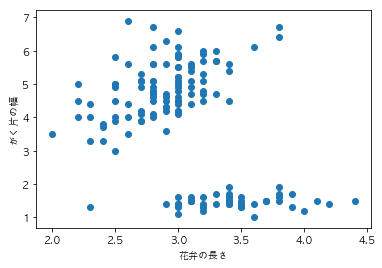

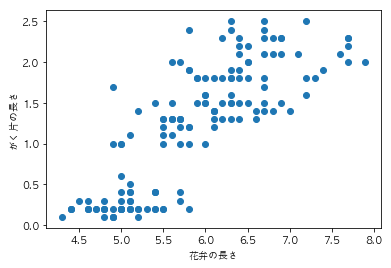

In [100]:
# がく片の長さ0 がく片の幅1 花弁の長さ2 花弁の幅3
plt.scatter(X.T[1],X.T[2])
plt.xlabel(r"花弁の長さ")
plt.ylabel(r"がく片の幅")
plt.show()
plt.scatter(X.T[0],X.T[3])
plt.xlabel(r"花弁の長さ")
plt.ylabel(r"がく片の長さ")
plt.show()

- - - - - - - - -

# イジング模型の相転移検出

- https://arxiv.org/abs/1605.01735 [Nature Physics volume13, pages431–434 (2017) ]
- Juan Carrasquilla, Roger G. Melko

configuration = https://www.dropbox.com/s/s92vk9omrgul3st/conf.zip?dl=0

## 彼らがやったこと

1. イジング模型の配位を相転移温度を含む範囲でモンテカルロで作成
2. 配位が高温相か低温相に属しているかでラベルを付ける
3. 配位の分類を画像の2値分類と思ってニューラルネットワークに学習させる
4. 出力層の値を$\beta$ の関数だとおもってプロットする
5. すると、相転移温度の所で出力値が交差する
6. 学習済みのニューラルネットワークに対して三角イジングの配位を入力(学習はしない)
7. 三角イジングの相転移温度も決まる

この他にも色々やっているが割愛。
今回は、2,3,4,5 までを行なう。理論的な考察などは適宜論文を参照のこと。

In [135]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
# For chainer
import chainer
from chainer import Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

# making data
from chainer.datasets import tuple_dataset

#Progress bar
from tqdm import tqdm

In [137]:
# 配位データのロードのためのユーティリティ

class param():
    def __init__(self, L = None, beta = None, JJ = 1, exth = 0.0):
        self.L = L # Lattice size
        self.beta = beta # temperature
        self.JJ = JJ # counpling # defoult value is one, ferro.
        self.exth = exth
    def get(self):
        return self.L, self.beta
def show_conf(p, conf):
    plt.imshow(conf.reshape(p.L,p.L), cmap='hot', interpolation='nearest')
    plt.show()

L, beta = (32, 0.57)


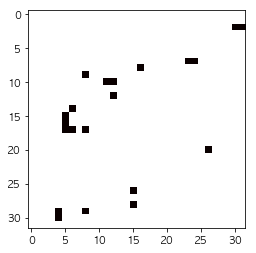

L, beta = (32, 0.55)


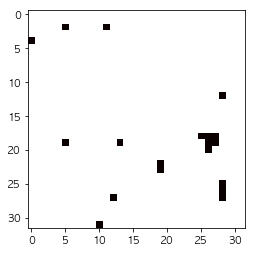

L, beta = (32, 0.53)


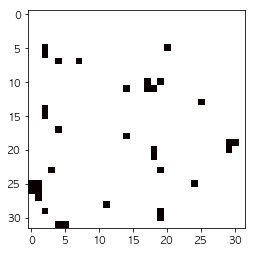

L, beta = (32, 0.51)


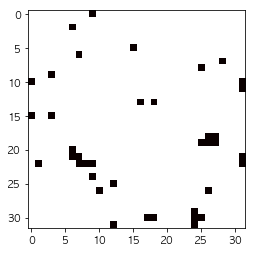

L, beta = (32, 0.49)


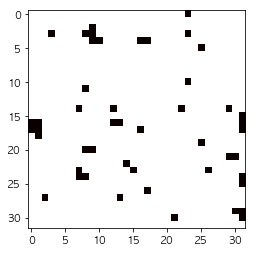

L, beta = (32, 0.47)


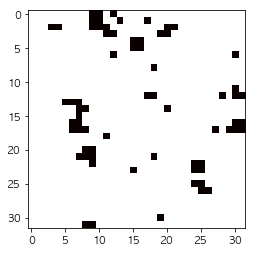

L, beta = (32, 0.45)


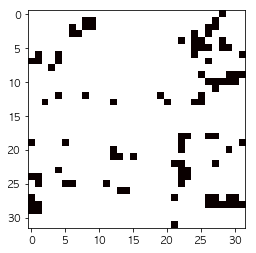

L, beta = (32, 0.43)


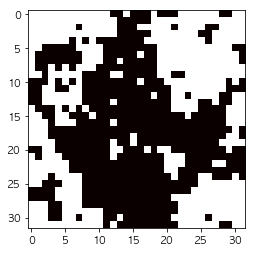

L, beta = (32, 0.41)


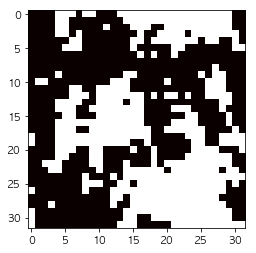

L, beta = (32, 0.39)


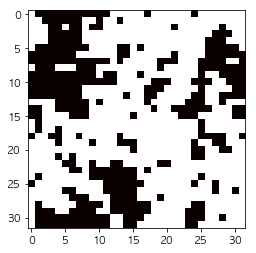

L, beta = (32, 0.37)


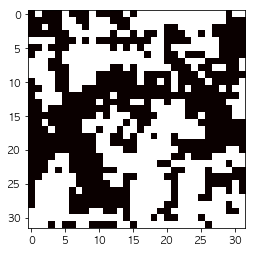

L, beta = (32, 0.35)


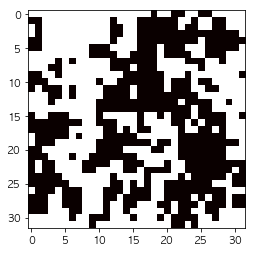

L, beta = (32, 0.33)


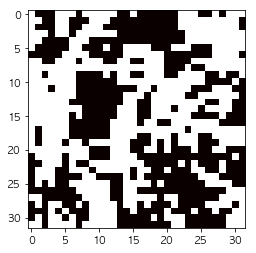

L, beta = (32, 0.31)


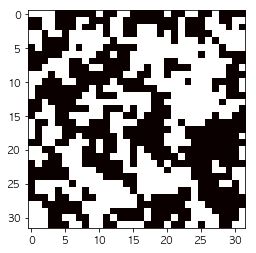

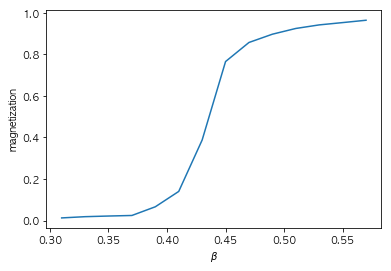

(7000, 1024) (7000,)
 # of train data = 6300
 # of test data = 700


In [138]:
# 配位データのロード

betas = [
         0.57, 0.55, 0.53, 0.51, 0.49, 0.47, 0.45, 
         0.43, 0.41, 0.39, 0.37, 0.35, 0.33, 0.31,
        ] # 7つのbeta での配位がある。
n_conf = 500 # 1 beta あたりの配位の数は500個。自己相関は切れている。
Lsize = 32 # 16の配位もあるのでここを変更すれば良い。
mags = []
p = param(L=Lsize, beta=betas[0])
labels = np.zeros(n_conf*len(betas) )
labels_beta = np.zeros(n_conf*len(betas) )
confs_t = np.zeros((n_conf*len(betas), p.L**2))
ii = 0
for beta in betas:
    confs = np.zeros((n_conf, p.L**2))
    for i_conf in range(n_conf):
        p = param(L=Lsize, beta=beta)
        fname = f"conf/isingconf_{p.L}_{p.beta}_{i_conf}.npy"
        conf = np.load(fname)
        if i_conf == n_conf-1:
            print(f"L, beta = {p.get()}")
            show_conf(p, conf)
        confs[i_conf] = np.copy(conf)
        label = 0
        if beta > 0.44: #ラベルつける
            label = 1 #ordered 相
        labels[ii] =  label 
        confs_t[ii] = np.copy(conf)
        labels_beta[ii] = beta
        ii += 1
    mags.append( np.mean(confs) )
plt.plot(betas, mags)
plt.xlabel(r"$\beta$")
plt.ylabel("magnetization")
plt.show()
print(np.shape(confs_t), np.shape(labels) )


#
confs_t=confs_t.astype(np.float32)
labels=labels.astype('i')

ndata = len(betas)*n_conf

index_train = [x for x in range(ndata) if x%10!=0]
index_test = [x for x in range(ndata) if x%10==0]

train = tuple_dataset.TupleDataset(confs_t[index_train], labels[index_train])
test = tuple_dataset.TupleDataset(confs_t[index_test], labels[index_test])
test_betas = labels_beta[index_test]

print( f" # of train data = {len(index_train )}" )
print( f" # of test data = {len(index_test )}" )

In [139]:
# 全結合ニューラルネットワークを定義する  (写経パート)
class NeuralNet_ising(chainer.Chain):
    def __init__(self, n_units, n_out=2):
        super().__init__(
            l1=L.Linear(None, n_units),
            l2=L.Linear(None, n_out),
        )
    def __call__(self, x):
        h1 = F.sigmoid(self.l1(x))
        h2 = self.l2(h1)
        return h2
    def trained(self, x):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.softmax(self.l2(h1))
        return h2
#
# 深い全結合ニューラルネットワークを定義する(オプション、これに変えても良い)  (空欄パート)
class NeuralNet_ising_deep(chainer.Chain):
    def __init__(self, n_units, n_out=2):
        super().__init__(
            l1=L.Linear(None, n_units),
            l2=L.Linear(None, n_units),
            l3=L.Linear(None, n_out),
        )
    def __call__(self, x):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = self.l3(h2)
        return h3
    def trained(self, x):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.softmax(self.l3(h2))
        return h3

In [140]:
def check_accuracy_ising(model, xs, ts):
    ys = model(xs)
    loss = F.softmax_cross_entropy(ys, ts)
    ys = np.argmax(ys.data, axis=1)
    cors = (ys == ts)
    num_cors = sum(cors)
    accuracy = num_cors / ts.shape[0]
    return accuracy, loss

In [131]:
def training_ising(N_epochs = 100):
    model = NeuralNet_ising(100)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    xs, ts = train._datasets
    txs, tts = test._datasets
    
    loss_history = []
    
    N_total_data = len(index_train)
    bm = 500 # subset size
    print(f"N_total_data = {N_total_data}, minibatch-size = {bm}" )
    for i in  range(N_epochs) :
        loss_history_minibatch = []
        for j in  range(N_total_data//bm) :
            model.zerograds()
            x = xs[(j * bm):((j + 1) * bm)]
            t = ts[(j * bm):((j + 1) * bm)]
            t = Variable(np.array(t, "i"))
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            loss_history_minibatch.append(loss.data)
            loss.backward()
            optimizer.update()
        loss_history.append(np.mean(loss_history_minibatch))
        accuracy_train, loss_train = check_accuracy_ising(model, xs, ts)
        accuracy_test, loss_history_test = check_accuracy_ising(model, txs, tts)
        if (i%20==0) | (i == N_epochs-1):
            print(f"Epoch {i + 1}/{N_epochs} loss(train) = {loss_train.data}, accuracy(train) = {accuracy_train}, accuracy(test) = {accuracy_test}" )
    return model, loss_history

N_total_data = 6300, minibatch-size = 500
Epoch 1/200 loss(train) = 0.7976325154304504, accuracy(train) = 0.6026984126984127, accuracy(test) = 0.6042857142857143
Epoch 21/200 loss(train) = 0.13768990337848663, accuracy(train) = 0.9665079365079365, accuracy(test) = 0.96
Epoch 41/200 loss(train) = 0.09186863899230957, accuracy(train) = 0.9712698412698413, accuracy(test) = 0.9585714285714285
Epoch 61/200 loss(train) = 0.0712362751364708, accuracy(train) = 0.9765079365079365, accuracy(test) = 0.9585714285714285
Epoch 81/200 loss(train) = 0.05719257891178131, accuracy(train) = 0.9811111111111112, accuracy(test) = 0.9585714285714285
Epoch 101/200 loss(train) = 0.04573671147227287, accuracy(train) = 0.9850793650793651, accuracy(test) = 0.9585714285714285
Epoch 121/200 loss(train) = 0.032889872789382935, accuracy(train) = 0.9895238095238095, accuracy(test) = 0.9585714285714285
Epoch 141/200 loss(train) = 0.024207327514886856, accuracy(train) = 0.9928571428571429, accuracy(test) = 0.95714285714

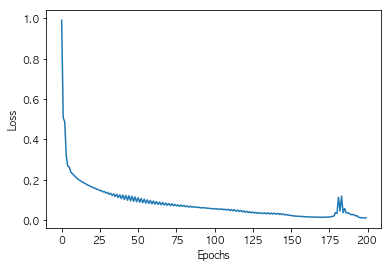

In [132]:
trained_model, loss_history = training_ising(N_epochs = 200)
x = range( len(loss_history) )
plt.plot(x, loss_history, label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

100%|██████████| 14/14 [00:00<00:00, 74.01it/s]


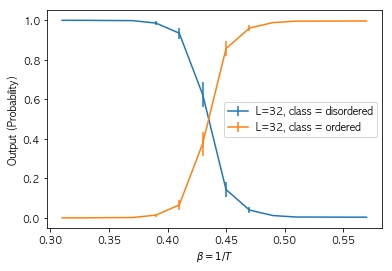

In [133]:
xs, ts = test._datasets
out1=[]
out2=[]
out1er=[]
out2er=[]
beta_x = []
N_conf_test = len(index_test)
nbeta = len(betas)
n_conf_beta=N_conf_test//nbeta

for idx in tqdm(range(nbeta)): #loop for beta
    out1_tmp = []
    out2_tmp = []
    for jj in range(n_conf_beta): #loop for configurations same beta
        x = xs[idx*n_conf_beta+jj : idx*n_conf_beta+jj+1]
        y = trained_model.trained(x)
        out1_tmp.append( y.data[0][0] )
        out2_tmp.append( y.data[0][1] )
    out1.append( np.mean(out1_tmp) )
    out2.append( np.mean(out2_tmp) )
    out1er.append( np.std(out1_tmp)/math.sqrt(n_conf_beta-1) )
    out2er.append( np.std(out2_tmp)/math.sqrt(n_conf_beta-1) )
    beta =  test_betas[idx*n_conf_beta]
    beta_x.append( beta)
plt.errorbar(beta_x, out1, yerr=out1er, label = f"L={Lsize}, class = disordered")
plt.errorbar(beta_x, out2, yerr=out2er, label = f"L={Lsize}, class = ordered")
plt.legend()
plt.ylabel(r"Output (Probability)")
plt.xlabel(r"$\beta = 1/T$")
plt.show()